# Regression and Other Stories: Golf

Golf putting accuracy: Fitting a nonlinear model using Stan. See Chapter 22 in Regression and Other Stories.

Note: portions of the code from this notebook has been borrowed from Josh Duncan's [excellent Julia adaptation of the original Gelman blog post](https://jduncstats.com/posts/2019-11-02-golf-turing/).

## Load Packages

In [1]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains
using StatsFuns: logistic

## Load Data

In [2]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Golf/data/golf.txt"
golf  = CSV.File(HTTP.get(data).body, delim=" ", missingstring="NA", header=3, normalizenames=true) |> DataFrame
first(golf , 6)

,x,n,y
,Int64,Int64,Int64
1,2,1443,1346
2,3,694,577
3,4,455,337
4,5,353,208
5,6,272,149
6,7,256,136


## Plot Data

In [3]:
pct_made = golf.y ./ golf.n
error = @. sqrt.((pct_made * (1 - pct_made) / golf.n));

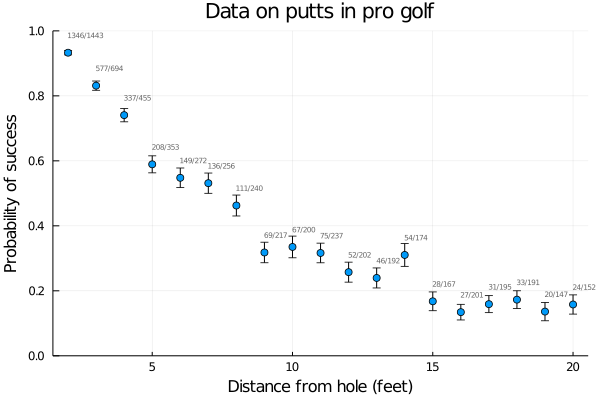

In [4]:
s=scatter(
    golf.x,
    pct_made,
    yerror = error,
    ylim=(0,1),
    xlabel="Distance from hole (feet)",
    ylabel="Probability of success",
    title="Data on putts in pro golf",
    legend=false
)

for p in 1:length(pct_made)
    annot = string(golf.y[p],"/",golf.n[p])
    annotate!(golf.x[p], pct_made[p] + 0.04, text(annot, :bottom,:left, :gray40, 5))
end
display(s)

## Logistic regression model

In [5]:
@model golf_logistic(x,y,n,J) = begin

    # parameters
    a ~ Normal(0, 1)
    b ~ Normal(0, 1)
    
    # model
    for i in 1:J
        p = logistic(a + b * x[i])
        y[i] ~ Binomial(n[i], p)
    end
end;

In [6]:
model1 = golf_logistic(golf.x, golf.y, golf.n, length(golf.x))
chain1 = sample(model1, NUTS(), 2000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turi

Chains MCMC chain (2000×14×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
parameters        = a, b
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           a    2.2215    0.0594     0.0013    0.0017   518.4880    1.0023
           b   -0.2547    0.0068     0.0002    0.0002   582.0871    1.0021

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           a    2.1084    2.1821    2.2215    2.2611    2.3362
           b   -0.2687   -0.2589   -0.2549   -0.2504   -0.2412


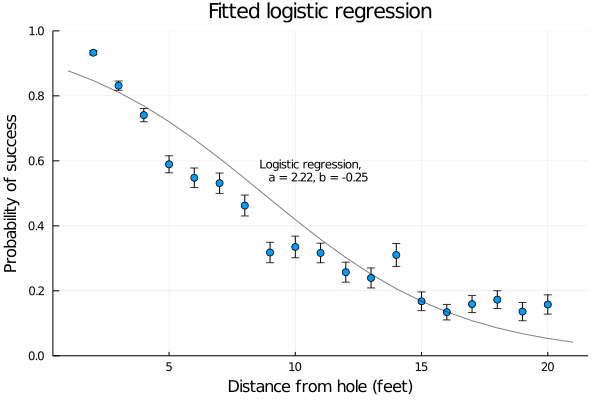

In [7]:
a_post = median(chain1[:a].data)
b_post = median(chain1[:b].data)

post_line = [logistic(a_post + b_post * x) for x = 1:21]

s=scatter(
    golf.x,
    pct_made,
    yerror = error,
    ylim=(0,1),
    xlabel="Distance from hole (feet)",
    ylabel="Probability of success",
    title="Fitted logistic regression",
    legend=false
)
plot!(post_line, alpha = 0.5, color = :black) # add uncertainty samples
annot=string(
    "Logistic regression,\n    a = ",round(a_post, digits=2), 
    ", b = ", round(b_post, digits=2)
)
annotate!(10.6, 0.57, text(annot,8) )

## Geometry based nonlinear model

In [8]:
Phi(x) = cdf.(Normal(0,1), x);

In [9]:
@model golf_angle(x, y, n, J, r, R) = begin
  # transformed data
  threshold_angle = asin.((R - r) ./ x)

  # parameters
  sigma ~ truncated(Normal(0, 1), 0, Inf)

  # model
  p = 2 * Phi(threshold_angle / sigma) .- 1
  for i in 1:J
    y[i] ~ Binomial(n[i], p[i])
  end
end;

r_ball = (1.68/2) / 12
r_hole = (4.25/2) / 12;

In [10]:
model2 = golf_angle(golf.x, golf.y, golf.n, length(golf.x), r_ball, r_hole)
chain2 = sample(model2, NUTS(), 2000)
# convert to degrees
chain2 = hcat(chain2, Chains(chain2[:sigma].data * 180/π, ["sigma_degrees"]))

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\tburch\.julia\packages\Turing\uAz5c\src\inference\hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\Advanced

Chains MCMC chain (2000×14×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Chains            = 1
Samples per chain = 2000
parameters        = sigma, sigma_degrees
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
     parameters      mean       std   naive_se      mcse        ess      rhat 
         Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

          sigma    0.0267    0.0004     0.0000    0.0000   954.1939    0.9999
  sigma_degrees    1.5270    0.0223     0.0005    0.0007   954.1939    0.9999

Quantiles
     parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
         Symbol   Float64   Float64   Float64   Float64   Float64 

          sigma    0.0259    0.0264    0.0266    0.0269    0.0274
  sigma_degrees    1.4843    1.5110    1.5269    1.5419    1.5

## Plot geometry based model result

In [11]:
# Utility function for angle calculation
prob_angle(threshold, sigma) = 2 * Phi(threshold / sigma) .- 1;

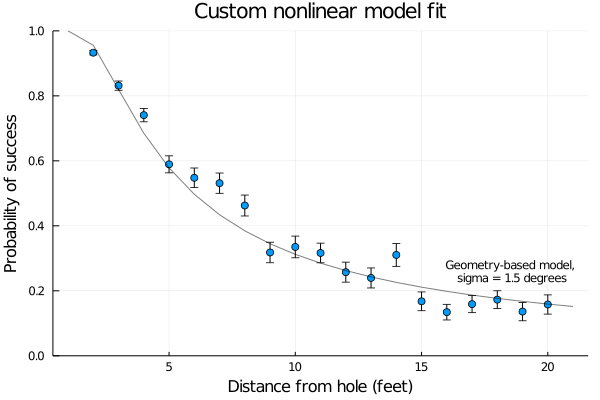

In [12]:
post_sigma = median(chain2[:sigma].data)

threshold_angle = [asin((r_hole - r_ball) / x) for x =1:21]
geom_line = prob_angle(threshold_angle, post_sigma)

s=scatter(
    golf.x,
    pct_made,
    yerror = error,
    ylim=(0,1),
    xlabel="Distance from hole (feet)",
    ylabel="Probability of success",
    title="Custom nonlinear model fit",
    legend=false
)
plot!(geom_line, alpha = 0.5, color = :black) 
annot=string(
    "Geometry-based model,\n sigma = ", 
    round(median(chain2[:sigma_degrees]), digits=1), " degrees"
)
annotate!(18.5, 0.26, text(annot,8) )

## Plot geometry based model posterior draws of sigma

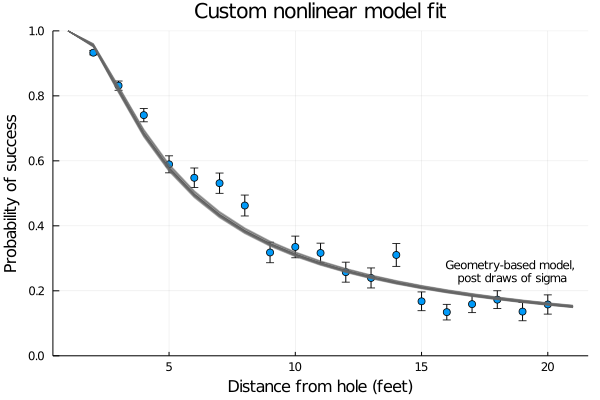

In [13]:
post_sigma = median(chain2[:sigma].data)

threshold_angle = [asin((r_hole - r_ball) / x) for x =1:21]
geom_line = prob_angle(threshold_angle, post_sigma)

# Plot data
s=scatter(
    golf.x,
    pct_made,
    yerror = error,
    ylim=(0,1),
    xlabel="Distance from hole (feet)",
    ylabel="Probability of success",
    title="Custom nonlinear model fit",
    legend=false
)
# Add median estimate
plot!(geom_line,color = :black)

# Add additional posterior draws
for s in sample(chain2[:sigma], 20)
    draw_line = prob_angle(threshold_angle, s)
    plot!(draw_line, alpha=0.5, color=:gray40)
end
        
annot=string(
    "Geometry-based model,\n post draws of sigma"
)
annotate!(18.5, 0.26, text(annot,8) )

## Plot two models in same figure

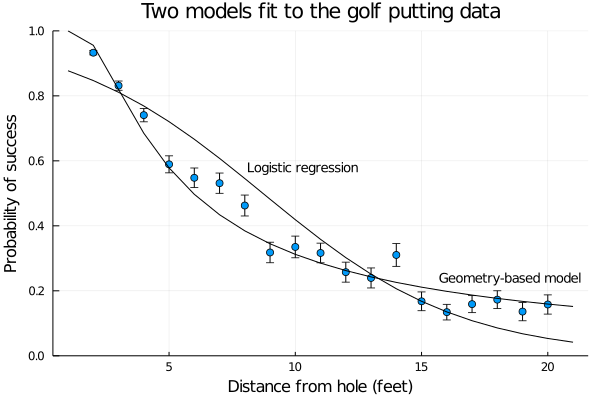

In [14]:
# Plot data
s=scatter(
    golf.x,
    pct_made,
    yerror = error,
    ylim=(0,1),
    xlabel="Distance from hole (feet)",
    ylabel="Probability of success",
    title="Two models fit to the golf putting data",
    legend=false
)

# Add nonlinear estimate
plot!(geom_line,color = :black)

# Add logistic estimate
plot!(post_line, color = :black)

annotate!(10.3, 0.58, text("Logistic regression",9) )
annotate!(18.5, 0.24, text("Geometry-based model",9) )